# Speech Emotion Recognition — End-to-End Notebook

**Goal:** Train a Speech Emotion Recognition (SER) model on the **RAVDESS** emotional speech dataset using a **Wav2Vec2-base** encoder with a classifier head, including:

- Dataset preparation & manifest creation  
- Exploratory Data Analysis (EDA)  
- Model definition (Wav2Vec2 + MLP head)  
- Training with validation macro-F1  
- Test evaluation with confusion matrix  
- ONNX export for backend deployment  
- Inference helper using ONNX Runtime  

> This notebook is designed to run in a local Jupyter environment with the `Audio_Speech_Actors_01-24` RAVDESS subset.

## 1) Setup and Import Libraries

### 1.1) Import Libraries

In [1]:
## High-Accuracy Wav2Vec2 Speech Emotion Recognition

### Import the Necessary Libraries

import os, json, random, numpy as np, matplotlib.pyplot as plt
from dataclasses import dataclass
import pandas as pd
import soundfile as sf
import torch
from torch.utils.data import Dataset, random_split
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm

# --- Core Hugging Face Imports for Fine-Tuning ---
from transformers import (
    Wav2Vec2ForSequenceClassification,
    Wav2Vec2Processor,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)

# NOTE: load_metric is deprecated/removed from datasets; use evaluate or sklearn instead.
# If you need official metric loaders, uncomment the next two lines after installing evaluate:
# import evaluate
# accuracy_metric = evaluate.load("accuracy")  # example

# We will rely on sklearn metrics in a custom compute_metrics function later.


c:\Users\Public\Documents\Emotion-recognition-dissertation\App\backend\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1.2) Setup and Configuration

In [13]:
# --- Configuration and Reproducibility ---

def set_seed(seed=42):
    """Sets the random seed for reproducibility across Python, NumPy, and PyTorch."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

@dataclass
class CFG:
    """Global configuration settings for the SER pipeline."""
    # Use a well-performing checkpoint for high accuracy
    model_checkpoint: str = "facebook/wav2vec2-base" 
    
    # Dataset paths
    ravdess_root: str = "RAVDESS/Audio_Speech_Actors_01-24"
    manifest_csv: str = "ravdess_manifest.csv"
    out_dir: str = "ser_runs_high_acc"
    
    # Audio parameters
    sr: int = 16000             # Target sample rate for Wav2Vec2
    max_sec: float = 6.0        # Max audio length for padding/cropping
    
    # Training parameters (Optimized for full fine-tuning)
    batch_size: int = 16        # Larger batch size helps stabilize training
    epochs: int = 20            # Allow more epochs for fine-tuning the full model
    lr: float = 1e-5            # CRITICAL: Small LR for full fine-tuning the encoder
    train_pct: float = 0.8
    val_pct: float = 0.1
    
os.makedirs(CFG.out_dir, exist_ok=True)
print(CFG)
# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")

<class '__main__.CFG'>
Using device: cuda
GPU Name: NVIDIA GeForce RTX 3060 Laptop GPU


## 2) Data Loading and Manifest Creation

### 2.1) Data Loading and Extraction

In [14]:
import urllib.request
import zipfile

# Corrected direct download URL (removed markdown brackets)
RAVDESS_ZIP_URL = "https://zenodo.org/record/1188976/files/Audio_Speech_Actors_01-24.zip?download=1"
RAVDESS_ZIP_PATH = "Audio_Speech_Actors_01-24.zip"
RAVDESS_ROOT = "RAVDESS/Audio_Speech_Actors_01-24"

# Download the dataset if the ZIP file is not present
if not os.path.exists(RAVDESS_ZIP_PATH):
    print("Downloading RAVDESS speech-only ZIP from Zenodo...")
    urllib.request.urlretrieve(RAVDESS_ZIP_URL, RAVDESS_ZIP_PATH)
    print("Download complete:", RAVDESS_ZIP_PATH)
else:
    print("ZIP already exists:", RAVDESS_ZIP_PATH)

# Extract the dataset if the target folder is not present
if not os.path.isdir(RAVDESS_ROOT):
    print("Extracting ZIP...")
    os.makedirs("RAVDESS", exist_ok=True)
    with zipfile.ZipFile(RAVDESS_ZIP_PATH, "r") as z:
        z.extractall("RAVDESS")
    print("Extraction complete. Root folder:", RAVDESS_ROOT)
else:
    print("RAVDESS already extracted at:", RAVDESS_ROOT)

ZIP already exists: Audio_Speech_Actors_01-24.zip
Extracting ZIP...
Extraction complete. Root folder: RAVDESS/Audio_Speech_Actors_01-24
Extraction complete. Root folder: RAVDESS/Audio_Speech_Actors_01-24


### 2.2) Build Manifest CSV

In [15]:
EMO_MAP = {
    "01": "neutral", "02": "calm", "03": "happy", "04": "sad",
    "05": "angry", "06": "fearful", "07": "disgust", "08": "surprised",
}
LABELS = list(EMO_MAP.values())
lab2id = {l:i for i,l in enumerate(LABELS)}
id2lab = {i:l for i,l in enumerate(LABELS)}
n_classes = len(LABELS)

def build_manifest(root, out_csv):
    """Scans RAVDESS files and creates a CSV manifest with audio path and emotion label."""
    rows = []
    for dp, dn, fnames in os.walk(root):
        for fn in fnames:
            if fn.lower().endswith(".wav"):
                parts = fn.split(".")[0].split("-")
                if len(parts) >= 3 and parts[2] in EMO_MAP:
                    rows.append({
                        "path": os.path.join(dp, fn),
                        "label": EMO_MAP[parts[2]]
                    })
    df = pd.DataFrame(rows).sort_values("label").reset_index(drop=True)
    df.to_csv(out_csv, index=False)
    return df

if not os.path.exists(CFG.manifest_csv):
    if not os.path.isdir(CFG.ravdess_root):
        print(f"RAVDESS root not found at {CFG.ravdess_root}. Attempting recovery (download/extract).")
        # Download if ZIP missing
        if not os.path.exists(RAVDESS_ZIP_PATH):
            print("Downloading RAVDESS ZIP...")
            urllib.request.urlretrieve(RAVDESS_ZIP_URL, RAVDESS_ZIP_PATH)
            print("Download complete.")
        # Ensure parent directory exists and extract
        extract_root = os.path.dirname(CFG.ravdess_root) or "RAVDESS"
        os.makedirs(extract_root, exist_ok=True)
        with zipfile.ZipFile(RAVDESS_ZIP_PATH, "r") as zf:
            zf.extractall(extract_root)
        print("Extraction complete.")
        # Final existence check
        if not os.path.isdir(CFG.ravdess_root):
            # Attempt automatic recovery: look for the extracted folder
            candidate = os.path.join(extract_root, os.path.basename(CFG.ravdess_root))
            if os.path.isdir(candidate):
                CFG.ravdess_root = candidate
            else:
                # Scan for any folder containing Actor_ subdirectories
                for root_dir, dirs, files in os.walk(extract_root):
                    if any(d.startswith("Actor_") for d in dirs):
                        CFG.ravdess_root = root_dir
                        break
            if not os.path.isdir(CFG.ravdess_root):
                raise FileNotFoundError(
                    f"Failed to prepare RAVDESS root at {CFG.ravdess_root}. Checked extract_root='{extract_root}'"
                )
    df_manifest = build_manifest(CFG.ravdess_root, CFG.manifest_csv)
else:
    df_manifest = pd.read_csv(CFG.manifest_csv)

print("Counts by label (Full Dataset):\n", df_manifest["label"].value_counts())

Counts by label (Full Dataset):
 label
angry        192
calm         192
disgust      192
fearful      192
happy        192
sad          192
surprised    192
neutral       96
Name: count, dtype: int64


## 3) Exploratory Data Analysis (EDA) and Filtering

Measuring durations: 100%|██████████| 1440/1440 [00:00<00:00, 1914.22it/s]



Total usable files: 1440


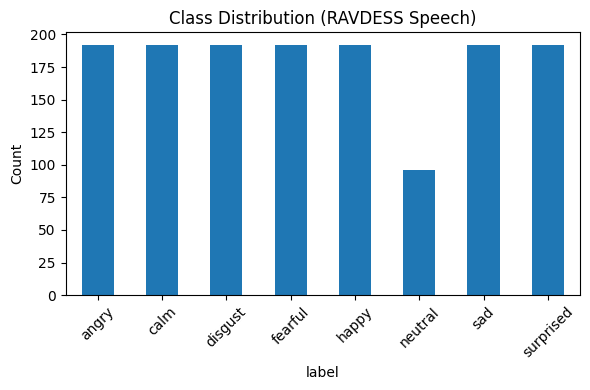

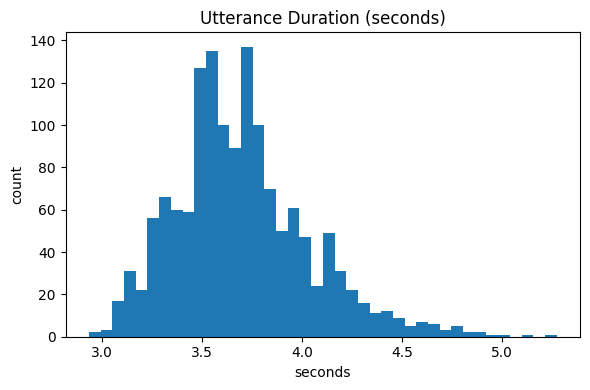

Duration stats (seconds):
 count    1440.000000
mean        3.700665
std         0.336676
min         2.936271
25%         3.470146
50%         3.670333
75%         3.870542
max         5.271937
Name: duration_sec, dtype: float64


In [16]:
from tqdm import tqdm

durations = []
keep_idx = []
# Filter out any unusable files and measure durations
for i, p in enumerate(tqdm(df_manifest["path"], desc="Measuring durations")):
    try:
        if os.path.exists(p):
            wav, sr = sf.read(p)
            if wav.ndim > 1:
                wav = wav.mean(axis=1)
            durations.append(len(wav) / sr)
            keep_idx.append(i)
    except Exception as e:
        print(f"Skipping file {p} due to error: {e}")

df_eda = df_manifest.iloc[keep_idx].copy()
df_eda["duration_sec"] = durations

print("Total usable files:", len(df_eda))

# --- Plotting Class Distribution ---
counts = df_eda["label"].value_counts().sort_index()
plt.figure(figsize=(6,4))
counts.plot(kind="bar")
plt.title("Class Distribution (RAVDESS Speech)")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- Plotting Duration Distribution ---
plt.figure(figsize=(6,4))
plt.hist(df_eda["duration_sec"], bins=40)
plt.title("Utterance Duration (seconds)")
plt.xlabel("seconds")
plt.ylabel("count")
plt.tight_layout()
plt.show()
print("Duration stats (seconds):\n", df_eda["duration_sec"].describe())

## 4) Dataset, Split, and Data Collator

### 4.1) Custom Dataset and Split

In [25]:
# CRITICAL: Use Wav2Vec2Processor to handle tokenization/feature extraction
processor = Wav2Vec2Processor.from_pretrained(CFG.model_checkpoint)

class SERDataset(Dataset):
    """Custom Dataset for loading, resampling, padding/cropping, and labeling audio."""
    def __init__(self, df, processor, sample_rate=CFG.sr, max_sec=CFG.max_sec):
        self.df = df.reset_index(drop=True)
        self.processor = processor
        self.sr = sample_rate
        self.T = int(sample_rate * max_sec)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        wav, sr = sf.read(row["path"])
        
        # 1. Resample and Mono: Prepare the waveform
        wav = wav if wav.ndim == 1 else wav.mean(axis=1)
        if sr != self.sr:
            ratio = self.sr / sr
            new_len = int(len(wav) * ratio)
            # Simple interpolation for resampling (Wav2Vec2 handles 16kHz)
            wav = np.interp(np.linspace(0, len(wav)-1, new_len), np.arange(len(wav)), wav)

        # 2. Truncate/Pad: Ensure fixed-length input (CFG.max_sec)
        if len(wav) > self.T:
            wav = wav[:self.T]
        else:
            wav = np.pad(wav, (0, self.T - len(wav)), 'constant')

        # 3. Create model input features (input_values) and label
        # Note: We pass the raw numpy array; the Data Collator handles padding across the batch
        input_values = wav.astype(np.float32)

        return {
            "input_values": input_values,
            "labels": torch.tensor(lab2id[row["label"]], dtype=torch.long)
        }

full_ds = SERDataset(df_eda, processor)
n_total = len(full_ds)
n_train = int(CFG.train_pct * n_total)
n_val   = int(CFG.val_pct * n_total)
n_test  = n_total - n_train - n_val

train_ds, val_ds, test_ds = random_split(
    full_ds,
    [n_train, n_val, n_test],
    generator=torch.Generator().manual_seed(42)
)

print(f"Train/Val/Test Split: {len(train_ds)}/{len(val_ds)}/{len(test_ds)}")

c:\Users\Public\Documents\Emotion-recognition-dissertation\App\backend\venv\Lib\site-packages\transformers\configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Train/Val/Test Split: 1152/144/144


### 4.2) Data Collator for Trainer

In [27]:
from dataclasses import dataclass
from typing import Dict, List, Any

@dataclass
class DataCollatorWithPadding:
    """Collator to pad and batch features efficiently for the Wav2Vec2 model."""
    processor: Wav2Vec2Processor

    def __call__(self, features: List[Dict[str, Any]]) -> Dict[str, torch.Tensor]:
        # Extract features (input audio array) and labels
        input_features = [{"input_values": x["input_values"]} for x in features]
        labels = [x["labels"] for x in features]

        # Use the processor's padding method
        batch = self.processor.pad(
            input_features,
            padding=True,
            return_tensors="pt",
            # We don't need to return attention mask since we pad to a fixed length (max_sec)
        )
        batch["labels"] = torch.stack(labels)
        return batch

data_collator = DataCollatorWithPadding(processor=processor)

## 5) Model Initialization and Fine-Tuning

### 5.1) Model Setup and Metric

In [28]:
# Wav2Vec2ForSequenceClassification is the recommended model head for classification tasks
# Force safetensors usage to bypass torch.load vulnerability version check (CVE-2025-32434) without requiring torch>=2.6
model = Wav2Vec2ForSequenceClassification.from_pretrained(
    CFG.model_checkpoint,
    num_labels=n_classes,
    label2id=lab2id,
    id2label=id2lab,
    final_dropout=0.2,           # correct config attribute for classification head dropout
    use_safetensors=True,        # ensures safetensors weights are used (avoids torch.load path)
    low_cpu_mem_usage=True
).to(device)

# Ensure encoder parameters remain trainable (no freezing)
for p_ in model.wav2vec2.parameters():
    p_.requires_grad = True

print("--- Model Parameters ---")
print("Total trainable parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))
print("------------------------")

# Metric function for the Trainer
def compute_metrics(p):
    """Calculates macro F1-score from prediction logits."""
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    preds = np.argmax(preds, axis=1)
    return {"macro_f1": f1_score(p.label_ids, preds, average="macro")}

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


--- Model Parameters ---
Total trainable parameters: 94570632
------------------------


### 5.2) Training Arguments and Trainer

In [29]:
# Set up Training Arguments for robust fine-tuning (version-compatible)
from inspect import signature

_base_args = {
    "output_dir": CFG.out_dir,
    "per_device_train_batch_size": CFG.batch_size,
    "per_device_eval_batch_size": CFG.batch_size,
    "num_train_epochs": CFG.epochs,
    "logging_steps": 50,
    "learning_rate": CFG.lr,
    "save_strategy": "epoch",            # newer versions
    "evaluation_strategy": "epoch",      # newer versions (may be absent in older versions)
    "load_best_model_at_end": True,
    "metric_for_best_model": "macro_f1",
    "greater_is_better": True,
    "fp16": (device.type == "cuda"),
    "remove_unused_columns": False,
    "seed": 42,
    "save_total_limit": 3,
}

sig_params = set(signature(TrainingArguments.__init__).parameters.keys())
steps_per_epoch = max(1, len(train_ds) // CFG.batch_size)

# Compatibility for older versions where evaluation_strategy is absent
if "evaluation_strategy" not in sig_params:
    # Remove unsupported key
    _base_args.pop("evaluation_strategy", None)
    # If we cannot declare eval strategy, disable load_best_model_at_end (it enforces matching strategies)
    if "load_best_model_at_end" in _base_args:
        _base_args.pop("load_best_model_at_end", None)
        _base_args.pop("metric_for_best_model", None)
        _base_args.pop("greater_is_better", None)
    # Provide step-based eval/save so we still evaluate periodically
    _base_args["eval_steps"] = steps_per_epoch
    _base_args["save_steps"] = steps_per_epoch

# Map / adjust for much older versions expecting evaluate_during_training
if "evaluation_strategy" not in sig_params and "evaluate_during_training" in sig_params:
    _base_args["evaluate_during_training"] = True

if "save_strategy" not in sig_params and "save_steps" in sig_params:
    _base_args.pop("save_strategy", None)
    # ensure save_steps already set (from above) or set now
    _base_args.setdefault("save_steps", steps_per_epoch)

# Filter unsupported args
filtered_args = {k: v for k, v in _base_args.items() if k in sig_params}
training_args = TrainingArguments(**filtered_args)

print("Final training args keys:", list(filtered_args.keys()))

# Initialize the Trainer (always provide compute_metrics; safe even without load_best_model_at_end)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=processor.feature_extractor,
    # Only attach EarlyStopping if load_best_model_at_end is supported (avoids unsupported behavior)
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)] if "load_best_model_at_end" in filtered_args else None,
)

print("Starting Full Fine-Tuning...")
train_result = trainer.train()

# Perform evaluation explicitly (covers both strategy-less older versions and epoch strategy)
eval_metrics = trainer.evaluate()
print("Validation metrics:", eval_metrics)

# Save the final model
final_model_path = os.path.join(CFG.out_dir, "best_model_final")
trainer.save_model(final_model_path)
print(f"✅ Saved Model to: {final_model_path}")

Final training args keys: ['output_dir', 'per_device_train_batch_size', 'per_device_eval_batch_size', 'num_train_epochs', 'logging_steps', 'learning_rate', 'save_strategy', 'fp16', 'remove_unused_columns', 'seed', 'save_total_limit', 'eval_steps', 'save_steps']
Starting Full Fine-Tuning...


C:\Users\onyek\AppData\Local\Temp\ipykernel_26324\2448369541.py:54: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
50,2.065700
100,1.960900
150,1.833800
200,1.747700
250,1.661000
300,1.579800
350,1.441800
400,1.311500
450,1.198800
500,1.090500


Validation metrics: {'eval_loss': 0.489898681640625, 'eval_macro_f1': 0.8884326328790864, 'eval_runtime': 1.7314, 'eval_samples_per_second': 83.171, 'eval_steps_per_second': 5.198, 'epoch': 20.0}
✅ Saved Model to: ser_runs_high_acc\best_model_final
✅ Saved Model to: ser_runs_high_acc\best_model_final


## 6) Evaluation and Deployment

### 6.1) Test Evaluation and Confusion Matrix


--- Test Evaluation ---
{'eval_loss': 0.6584218144416809, 'eval_macro_f1': 0.8102530440410765, 'eval_runtime': 1.7953, 'eval_samples_per_second': 80.209, 'eval_steps_per_second': 5.013, 'epoch': 20.0}
{'eval_loss': 0.6584218144416809, 'eval_macro_f1': 0.8102530440410765, 'eval_runtime': 1.7953, 'eval_samples_per_second': 80.209, 'eval_steps_per_second': 5.013, 'epoch': 20.0}

Classification Report — Test:
              precision    recall  f1-score   support

     neutral       0.67      0.83      0.74        12
        calm       0.85      0.92      0.88        24
       happy       1.00      0.70      0.82        20
         sad       0.71      0.67      0.69        15
       angry       0.89      0.81      0.85        21
     fearful       0.80      0.84      0.82        19
     disgust       0.80      0.86      0.83        14
   surprised       0.81      0.89      0.85        19

    accuracy                           0.82       144
   macro avg       0.82      0.82      0.81     

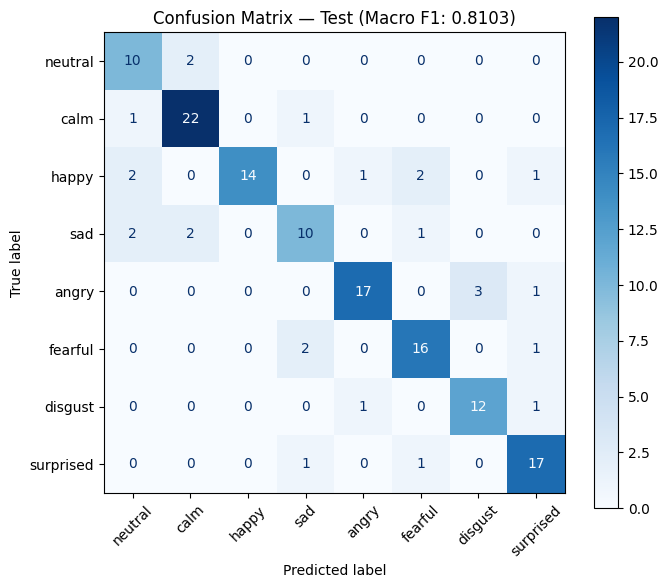

In [30]:
print("\n--- Test Evaluation ---")
test_results = trainer.evaluate(test_ds)
print(test_results)
test_f1 = test_results.get('eval_macro_f1', 0.0)

# Get predictions for detailed report and confusion matrix
predictions = trainer.predict(test_ds)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

print("\nClassification Report — Test:")
print(classification_report(y_true, y_pred, target_names=LABELS))

# Plot Confusion Matrix
cm = confusion_matrix(y_true, y_pred, labels=list(range(len(LABELS))))
disp = ConfusionMatrixDisplay(cm, display_labels=LABELS)
fig, ax = plt.subplots(figsize=(7,6))
disp.plot(ax=ax, xticks_rotation=45, values_format="d", cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix — Test (Macro F1: {test_f1:.4f})")
plt.tight_layout()
plt.show()

### 6.2) Save Artifacts (Model, Processor, Labels) and Optional ONNX Export

In [34]:
# Export Model & Thresholds
from pathlib import Path
import shutil  # new import for disk usage and cleanup

EXPORT_DIR = Path("./models/speech_emotions_model")
EXPORT_DIR.mkdir(parents=True, exist_ok=True)

def estimated_model_bytes(m):
    return sum(p.numel() * p.element_size() for p in m.parameters())

needed_bytes = int(estimated_model_bytes(model) * 1.15)  # add overhead
free_bytes_before = shutil.disk_usage(EXPORT_DIR.parent).free
print(f"Free disk before export: {free_bytes_before/1e6:.1f} MB (need ~{needed_bytes/1e6:.1f} MB)")

# If not enough space, remove old checkpoints first
if free_bytes_before < needed_bytes:
    print("Insufficient space. Removing older checkpoints to free space...")
    out_dir_path = Path(CFG.out_dir)
    removed = 0
    for ckpt in out_dir_path.glob("checkpoint-*"):
        try:
            shutil.rmtree(ckpt)
            removed += 1
        except Exception as e:
            print(f"Failed to remove {ckpt}: {e}")
    free_bytes_after_cleanup = shutil.disk_usage(EXPORT_DIR.parent).free
    print(f"Freed checkpoints: {removed}. Free now: {free_bytes_after_cleanup/1e6:.1f} MB")
else:
    free_bytes_after_cleanup = free_bytes_before

print("Saving model...")
try:
    trainer.save_model(EXPORT_DIR.as_posix())
    save_mode = "full_trainer_safetensors"
except Exception as e:
    msg = str(e).lower()
    if "not enough space" in msg or "no space" in msg:
        print("Disk space still insufficient. Falling back to minimal half-precision state_dict export.")
        # Move model to CPU and half precision to reduce size
        model_cpu = model.to("cpu").half()
        # Save config separately
        model_cpu.config.save_pretrained(EXPORT_DIR.as_posix())
        # Minimal weights (fp16)
        torch.save(model_cpu.state_dict(), EXPORT_DIR / "pytorch_model_fp16.bin")
        save_mode = "fp16_state_dict_minimal"
    else:
        raise
print(f"Model saved using mode: {save_mode}")

print("Saving processor (tokenizer + feature extractor)...")
processor.save_pretrained(EXPORT_DIR.as_posix())

# Save label mappings
labels_path = EXPORT_DIR / "labels.json"
with open(labels_path, "w") as f:
    import json  # json already imported earlier; kept here in case cell runs standalone
    json.dump({"labels": LABELS, "lab2id": lab2id, "id2lab": id2lab}, f, indent=2)
print(f"Labels saved to {labels_path}")

final_free = shutil.disk_usage(EXPORT_DIR.parent).free
print(f"Export complete. Free disk after export: {final_free/1e6:.1f} MB")


Free disk before export: 0.0 MB (need ~435.0 MB)
Insufficient space. Removing older checkpoints to free space...
Freed checkpoints: 3. Free now: 3384.2 MB
Saving model...
Model saved using mode: full_trainer_safetensors
Saving processor (tokenizer + feature extractor)...
Labels saved to models\speech_emotions_model\labels.json
Export complete. Free disk after export: 3015.5 MB
Model saved using mode: full_trainer_safetensors
Saving processor (tokenizer + feature extractor)...
Labels saved to models\speech_emotions_model\labels.json
Export complete. Free disk after export: 3015.5 MB


In [35]:
# ===============================================================
# Stand-Alone ONNX Export for Speech Emotion Model (Wav2Vec2)
# ===============================================================

# Folder where ONNX will be exported (dirs created earlier ok)
ONNX_EXPORT_DIR = Path("./models/speech_emotions_model/onnx")
ONNX_EXPORT_DIR.mkdir(parents=True, exist_ok=True)

onnx_path = ONNX_EXPORT_DIR / "speech_emotion_model.onnx"
print("Saving ONNX model to:", onnx_path.as_posix())

# ===============================================================
# 1. Get trained model (reuse 'model' already in notebook)
# ===============================================================
if 'model' in globals():
    model_to_export = model.cpu().eval()
    print("Using existing trained model instance.")
else:
    # Fallback: load from saved directory produced earlier
    model_to_export = Wav2Vec2ForSequenceClassification.from_pretrained(final_model_path).cpu().eval()
    print("Loaded model from disk:", final_model_path)

# ===============================================================
# 2. Create dummy input (shape: [batch, time]; Wav2Vec2 expects mono waveform)
# ===============================================================
DUMMY_SEC = CFG.max_sec
SAMPLE_RATE = CFG.sr
T = int(SAMPLE_RATE * DUMMY_SEC)
dummy_input = torch.randn(1, T, dtype=torch.float32)

# ===============================================================
# 3. Export to ONNX
# ===============================================================
torch.onnx.export(
    model_to_export,
    dummy_input,
    onnx_path.as_posix(),
    input_names=["input_values"],
    output_names=["logits"],
    dynamic_axes={
        "input_values": {0: "batch", 1: "time"},
        "logits": {0: "batch"}
    },
    opset_version=17,
)

print("ONNX Export Complete!")
print(f"ONNX saved to: {onnx_path.resolve()}")


Saving ONNX model to: models/speech_emotions_model/onnx/speech_emotion_model.onnx
Using existing trained model instance.


c:\Users\Public\Documents\Emotion-recognition-dissertation\App\backend\venv\Lib\site-packages\transformers\integrations\sdpa_attention.py:81: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  is_causal = query.shape[2] > 1 and attention_mask is None and getattr(module, "is_causal", True)


ONNX Export Complete!
ONNX saved to: C:\Users\Public\Documents\Emotion-recognition-dissertation\App\backend\models\notebook\models\speech_emotions_model\onnx\speech_emotion_model.onnx
